# Convolutional Neural Networks - Tensorflow

The architecture of this ConvNet: 
Conv2D(f:[4,4,3] * 8) -> ReLU -> MaxPoolingLayer -> Conv2D(f:[2,2,8] * 16) -> ReLU -> MaxPoolingLayer -> FC -> Softmax output

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

/Users/Shawn/anaconda2/envs/py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

the SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

<img src="images/SIGNS.png" style="width:800px;height:300px;">

y = 2


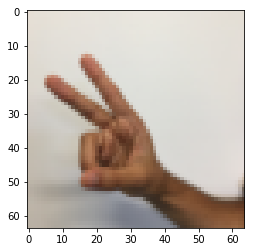

In [3]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [4]:
#Normalize the traning and testing data
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [5]:
# create_placeholders for input training/testing images

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(dtype="float",shape=(None,n_H0,n_W0,n_C0),name='X')
    Y = tf.placeholder(dtype="float",shape=(None,n_y),name='Y')
    
    return X, Y

In [6]:
#intialize required filter/kernel weights using Xavier initializer
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)
        
    W1 = tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

### Forward propagation
Useful functions:
- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). Full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. Full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)

- **tf.nn.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

- **tf.contrib.layers.flatten(P)**: given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k]. Full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)

- **tf.contrib.layers.fully_connected(F, num_outputs):** given a the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected) (!!! Fully connected layer automatically initializes weights in the graph and keeps on training them)

In [7]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding="SAME")
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding="SAME")
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. 
    Z3 = tf.contrib.layers.fully_connected(P2,6,activation_fn=None)
    
    return Z3

### Compute cost
Useful functions:
- **tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y):** computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss.Full documentation  [here.](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
- **tf.reduce_mean:** computes the mean of elements across dimensions of a tensor. Use this to sum the losses over all the examples to get the overall cost. Full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)


In [8]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

## 1.4 Model 

The model will:
- create placeholders
- initialize parameters ([Hint for initializing the variables](https://www.tensorflow.org/api_docs/python/tf/global_variables_initializer))
- forward propagate
- compute the cost
- create an optimizer

In [9]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    ### Create the computational graph ###
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    # Initialize parameters
    parameters = initialize_parameters()   
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    ### Run the computational graph ###
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        saver.save(sess,"saved_model/model.ckpt")
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.917929
Cost after epoch 5: 1.506757
Cost after epoch 10: 0.955359
Cost after epoch 15: 0.845802
Cost after epoch 20: 0.701173
Cost after epoch 25: 0.570725
Cost after epoch 30: 0.531806
Cost after epoch 35: 0.522357
Cost after epoch 40: 0.426237
Cost after epoch 45: 0.416917
Cost after epoch 50: 0.392239
Cost after epoch 55: 0.351203
Cost after epoch 60: 0.300881
Cost after epoch 65: 0.299140
Cost after epoch 70: 0.319066
Cost after epoch 75: 0.292510
Cost after epoch 80: 0.270511
Cost after epoch 85: 0.298058
Cost after epoch 90: 0.211864
Cost after epoch 95: 0.164706


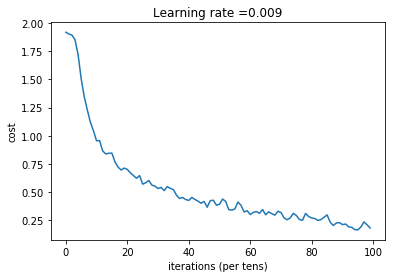

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.92963
Test Accuracy: 0.791667


In [10]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

## Load the saved model and evaluate the result

In [15]:
def loadModel():
    # to be able to rerun the model without overwriting tf variables  
    tf.reset_default_graph() 
    sess = tf.InteractiveSession()
    
    #restore graph architecture
    saver = tf.train.import_meta_graph('saved_model/model.ckpt.meta')
    #restore the model
    saver.restore(sess,tf.train.latest_checkpoint('./saved_model/'))
    
    return sess

In [16]:
def evaluate(sess,X_test,Y_test):
    
    #get placeholders and FC layer output
    X= graph.get_tensor_by_name("X:0")
    Y = graph.get_tensor_by_name("Y:0")
    Z3 = graph.get_tensor_by_name('fully_connected/BiasAdd:0')
    A3 = tf.nn.softmax(Z3)
    
    #predict
    predict_op = tf.argmax(A3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))   
    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    return sess.run([predict_op,accuracy],feed_dict={X:X_test,Y:Y_test})

In [17]:
sess=loadModel()
graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from ./saved_model/model.ckpt


In [18]:
_ , train_accuracy = evaluate(sess,X_train,Y_train)
_ , test_accuracy  = evaluate(sess,X_test,Y_test)
print("training accuracy: ", train_accuracy)
print("testing accuracy: ", test_accuracy)


training accuracy:  0.92963
testing accuracy:  0.791667
